In [1]:
# basic python data handling analysis modules
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
# small utility functions
from utility import *

# interactive jupyter widgets!
# https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

%matplotlib inline

In [2]:
Dataset_directory = ".."+os.sep+"Datasets"+os.sep

In [3]:
INT_df = pd.read_msgpack(Dataset_directory+"Processed"+os.sep+"INT_df_with_aggregate"+".msgpack")

In [4]:
tv_series_mislabelled_as_a_movie = INT_df[INT_df["TMB_tv_not_film"]==1].index
INT_df.drop(tv_series_mislabelled_as_a_movie,inplace=True)


In [5]:
INT_df.dtypes.value_counts()

float64    897
object      35
int64        1
dtype: int64

In [6]:
object_columns = INT_df.columns[INT_df.dtypes=="object"]

In [7]:
object_columns

Index(['TMB_homepage', 'TMB_original_title', 'TMB_overview', 'TMB_poster_path',
       'TMB_production_companies', 'TMB_production_countries',
       'TMB_release_date', 'TMB_spoken_languages', 'TMB_status', 'TMB_tagline',
       'TMB_title', 'TMB_keyword_id_list', 'TMB_cast_list', 'TMB_crew_list',
       'HETREC_title', 'HETREC_spanishTitle', 'HETREC_imdbPictureURL',
       'HETREC_rtID', 'HETREC_rtPictureURL', 'HETREC_country',
       'HETREC_directorID', 'HETREC_directorName', 'SER_title',
       'SER_releaseDate', 'SER_directedBy', 'SER_starring', 'SER_genres',
       'SER_director_list', 'SER_genres_list', 'SER_starring_list', 'ML_title',
       'ML_genres', 'NUM_date', 'NUM_title', 'NUM_link'],
      dtype='object')

In [17]:
list_of_dummy_prefixes = ["original_language","spoken_languages","production_countries",
                          "production_companies","keyword","cast","crew"]
list_of_dummy_prefixes =[]

INT_df_ord_only = INT_df.copy() # work with a safe copy

object_columns = INT_df_ord_only.columns[INT_df.dtypes=="object"]
INT_df_ord_only.drop(object_columns,axis=1,inplace=True)

dummy_reg_exp = "TMB_("+"|".join(list_of_dummy_prefixes)+")_"
dummy_columns = [x for x in INT_df_ord_only.columns if re.match(dummy_reg_exp,x)]
if "TMB_crew_size" in dummy_columns: dummy_columns.remove("TMB_crew_size")
if "TMB_cast_size" in dummy_columns: dummy_columns.remove("TMB_cast_size") 

INT_df_ord_only.drop(dummy_columns,axis=1,inplace=True)

id_columns = [x for x in INT_df_ord_only.columns if re.search("Id|_id|ID",x)]
id_columns.extend(["TMB_collectionId","TMB_original_language","NUM_scrape_count","NUM_page_no"])
INT_df_ord_only = INT_df_ord_only.drop(id_columns,axis=1)

sample_size_variables = [x for x in INT_df_ord_only.columns if re.search("_n$|_n_x$|_n_y$",x.lower())]
INT_df_ord_only = INT_df_ord_only.drop(sample_size_variables,axis=1)

# normalised_variables = [x for x in INT_df_ord_only.columns if re.search("normalised",x.lower())]
# INT_df_ord_only = INT_df_ord_only.drop(normalised_variables,axis=1)

unnormalised_variables = [x.split("_normalised")[0] for x in INT_df.columns if re.search("normalised",x.lower())]
INT_df_ord_only = INT_df_ord_only.drop(unnormalised_variables,axis=1)


alternate_year_variables = ["TMB_years_since_first_movie","TMB_release_decade","TMB_release_year","NUM_release_year","HETREC_year",
                            "TMB_release_month","NUM_release_month","TMB_release_day","NUM_release_day"]
INT_df_ord_only = INT_df_ord_only.drop(alternate_year_variables,axis=1)

excess_gross_variables = ['NUM_domestic_gross','NUM_international_gross','NUM_worldwide_gross_divided_by_budget',
                          'TMB_budget_normalised', 'TMB_revenue_normalised', 'TMB_revenue_divided_by_budget_normalised',
                          'NUM_worldwide_gross',
                          'NUM_production_budget']
INT_df_ord_only = INT_df_ord_only.drop(excess_gross_variables,axis=1)


excess_hetrec_variables = ['HETREC_rtAllCriticsNumFresh','HETREC_rtAllCriticsNumRotten',
                           'HETREC_rtTopCriticsNumFresh','HETREC_rtTopCriticsNumRotten']
INT_df_ord_only = INT_df_ord_only.drop(excess_hetrec_variables,axis=1)

# p_values
pers_p_values = [x for x in INT_df_ord_only.columns if re.search("_p$",x.lower())]
INT_df_ord_only = INT_df_ord_only.drop(pers_p_values,axis=1)

# SER variables
excess_ser_variables = [x for x in INT_df_ord_only.columns if re.search("SER_(predictedRating|s\d|s_|q|m)",x)]
INT_df_ord_only = INT_df_ord_only.drop(excess_ser_variables,axis=1)

# choose one of score/rating/fraction -> noise_variance suggests keep score, ditch rest
excess_hetrec_variables = [x for x in INT_df_ord_only.columns if re.search("HETREC_rt\w*(Rating$)|FractionFresh",x)]
INT_df_ord_only = INT_df_ord_only.drop(excess_hetrec_variables,axis=1)

# 
too_low_variation = ["TMB_adult","TMB_video"]
INT_df_ord_only = INT_df_ord_only.drop(too_low_variation,axis=1)

Other_variables = [x for x in INT_df_ord_only.columns if "_Other" in x]
INT_df_ord_only = INT_df_ord_only.drop(Other_variables,axis=1)


In [9]:
INT_df_ord_only.shape

(59324, 818)

In [23]:
%%time
def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())

naive_cross_corrs = INT_df_ord_only.corr()    
pd.set_option('max_colwidth', 60)
corrank(naive_cross_corrs) # prints a descending list of correlation pair (Max on top)

                                                              pairs      corr
325606  (HETREC_rtAllCriticsNumReviews, HETREC_rtTopCriticsNumRe...  0.959386
327863  (gender_guess_integrated_cast_mean, gender_guess_integra...  0.940285
328443            (importulence_crew_mean, importulence_crew_lead5)  0.938709
326199                          (SER_ratings_mean, ML_ratings_mean)  0.937841
311885  (TMB_production_countries_South Korea, TMB_original_lang...  0.923408
328052         (credit_number_cast_mean, credit_number_cast_lead10)  0.919707
318063  (TMB_spoken_languages_Malayalam, TMB_original_language_M...  0.914914
328246  (department_number_crew_mean, department_number_crew_lead5)  0.907926
311836  (TMB_production_countries_South Korea, TMB_spoken_langua...  0.904870
327828  (gender_guess_integrated_crew_mean, gender_guess_integra...  0.899016
317625  (TMB_spoken_languages_Korean, TMB_original_language_Korean)  0.897822
308463  (TMB_production_countries_Iran, TMB_original_language_Pe

In [13]:
# Needed for Factor Analysis
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

average log-likelihood of all samples: -1057.0160522134352
number of iterations: 5
Wall time: 1min 38s


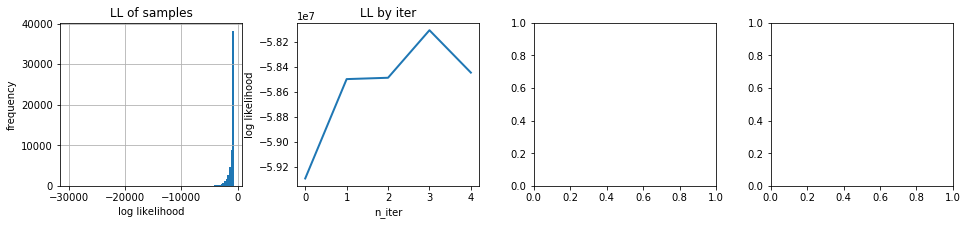

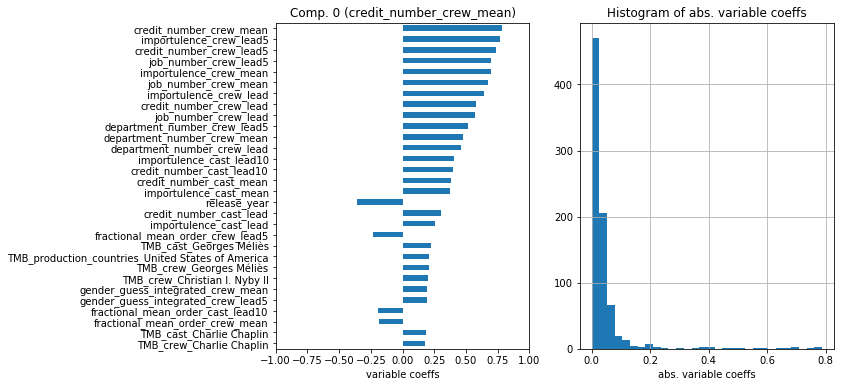

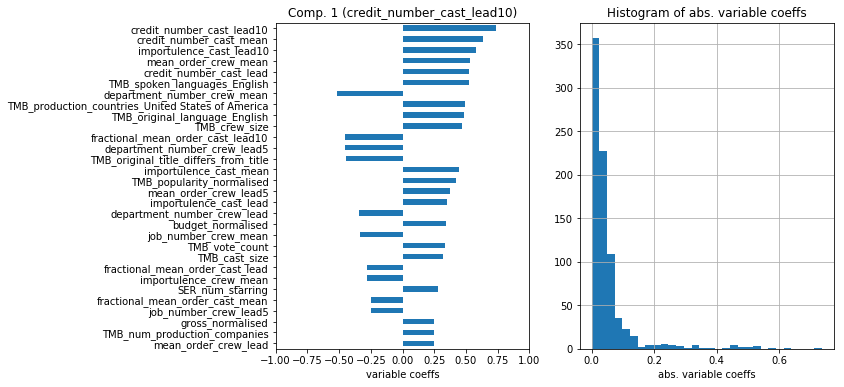

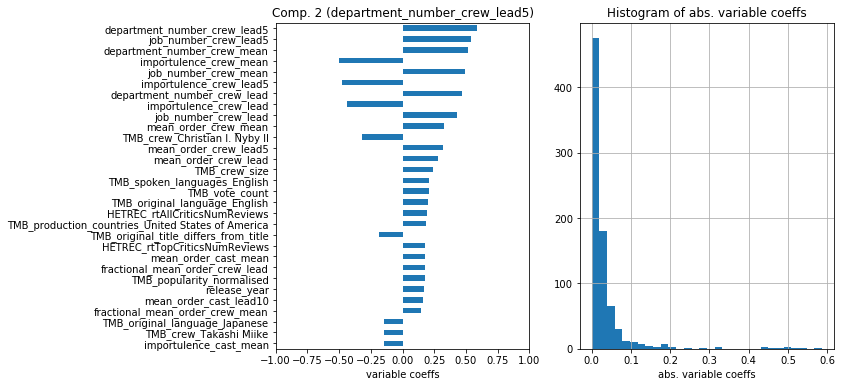

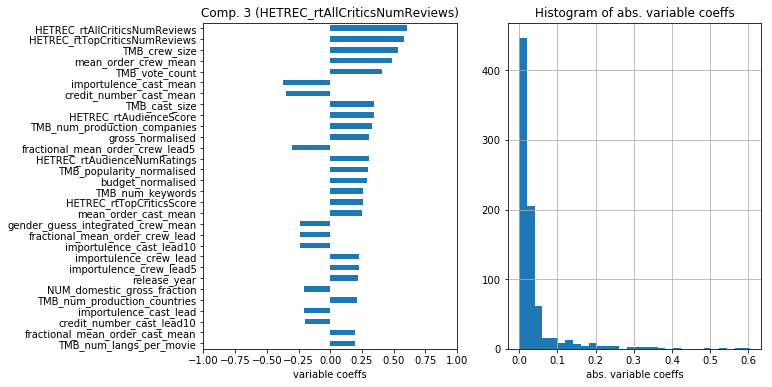

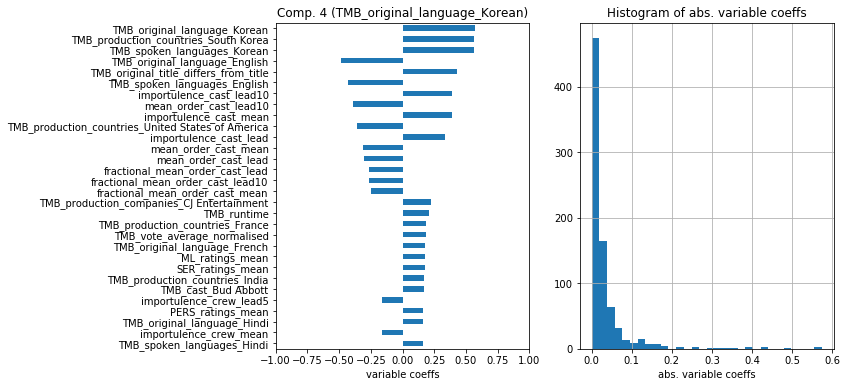

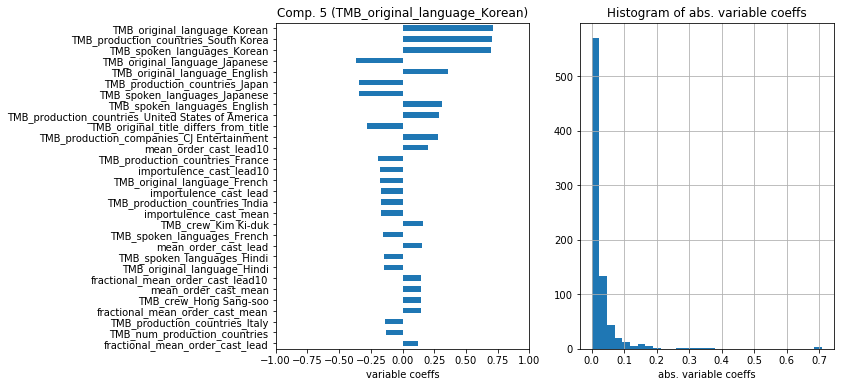

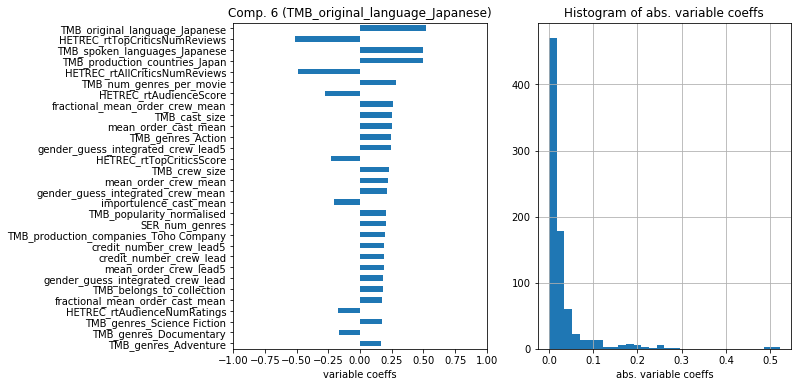

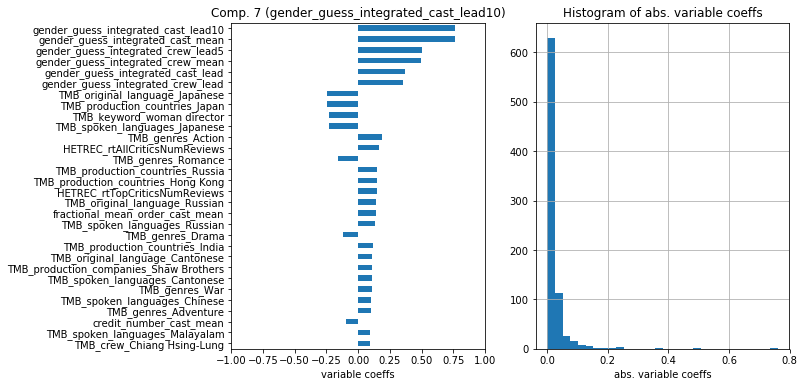

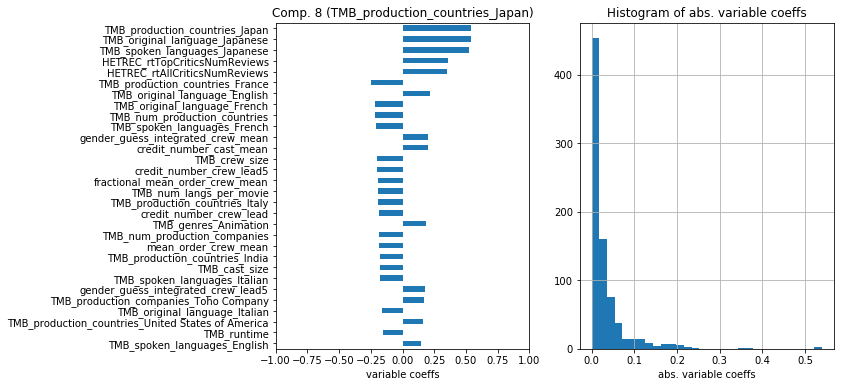

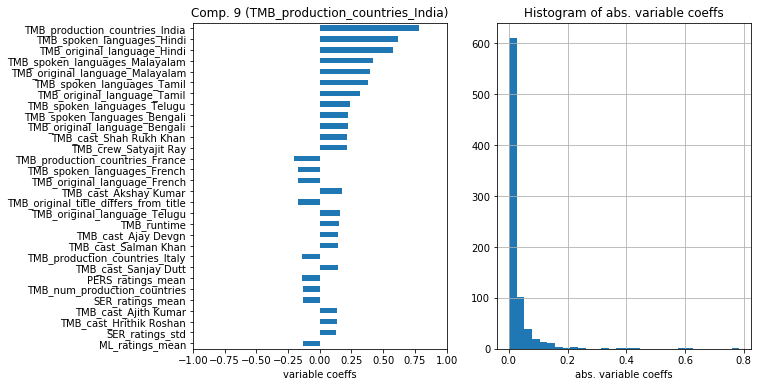

In [22]:
%%time

df = INT_df_ord_only.fillna(INT_df_ord_only.mean()).copy()




output_subfolder = ".."+os.sep+"Output"+os.sep + "numerical_only_with_agg_crew_cast_data" + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )
    

# standardise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(df.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = df.columns,
                             index   = df.index      )



n_components = BES_std.shape[1]
# n_components = 3

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = df.index)



load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method


display_pca_data(n_components, decomp, BES_std)



(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          df.columns, BES_decomp, manifest=None, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 10, show_histogram = True)

Warning, filename truncated because it was over 50. Filenames may no longer be unique


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:36:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.09997
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:1.07738
[2]	validation_0-rmse:1.05883
[3]	validation_0-rmse:1.04037
[4]	validation_0-rmse:1.02333
[5]	validation_0-rmse:1.00751
[6]	validation_0-rmse:0.994287
[7]	validation_0-rmse:0.977428
[8]	validation_0-rmse:0.964058
[9]	validation_0-rmse:0.952059
[10]	validation_0-rmse:0.941185
[11]	validation_0-rmse:0.930826
[12]	validation_0-rmse:0.921357
[13]	validation_0-rmse:0.912187
[14]	validation_0-rmse:0.904598
[15]	validation_0-rmse:0.895274
[16]	validation_0-rmse:0.887174
[17]	validation_0-rmse:0.878713
[18]	validation_0-rmse:0.870278
[19]	validation_0-rmse:0.86346
[20]	validation_0-rmse:0.858328
[21]	validation_0-rmse:0.852403
[22]	validation_0-rmse:0.845745
[23]	validation_0-rmse:0.840267
[24]

MSE: 0.55, MAE: 0.53, EV: 0.46, R2: 0.46


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:37:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


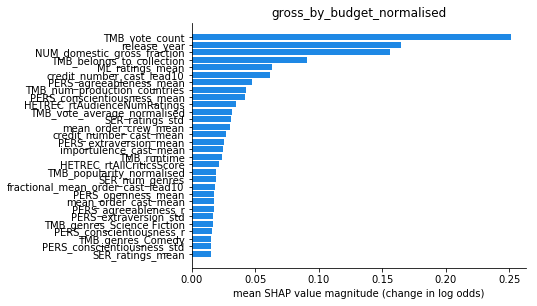

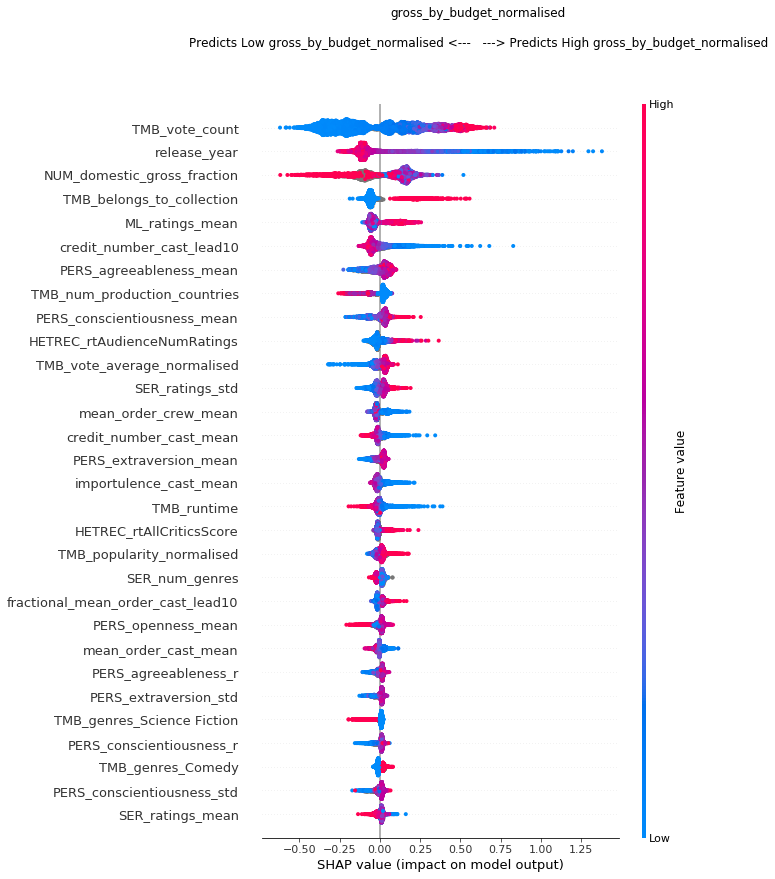

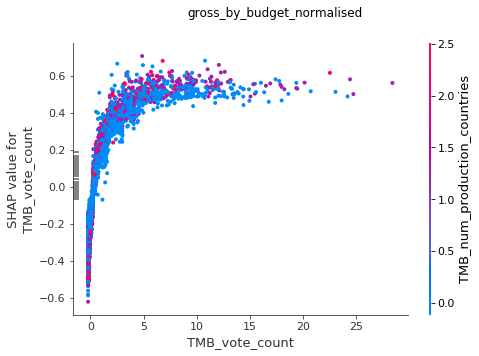

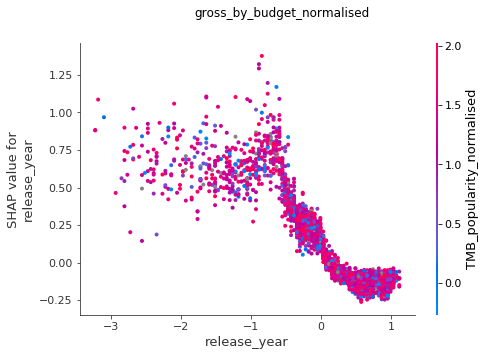

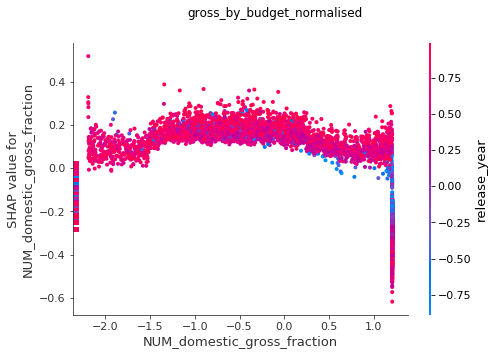

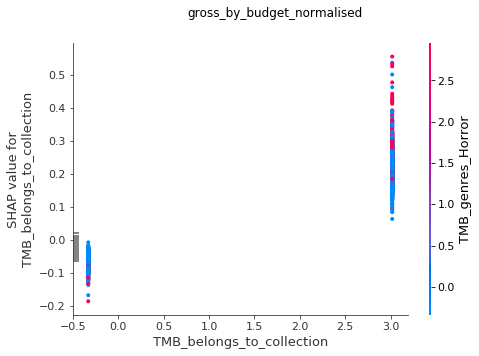

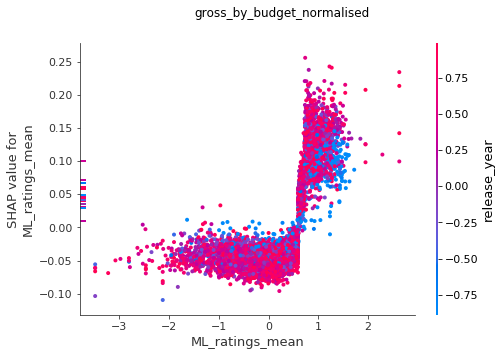

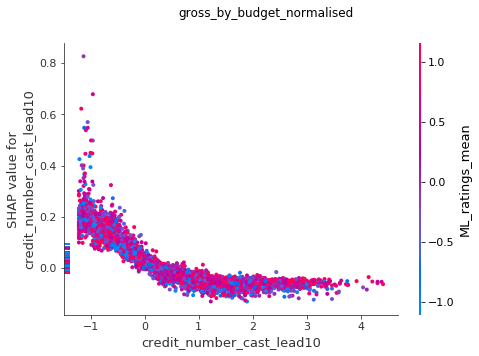

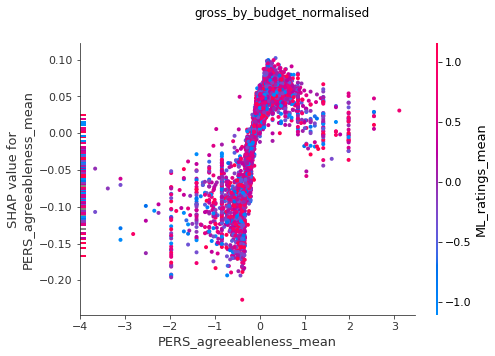

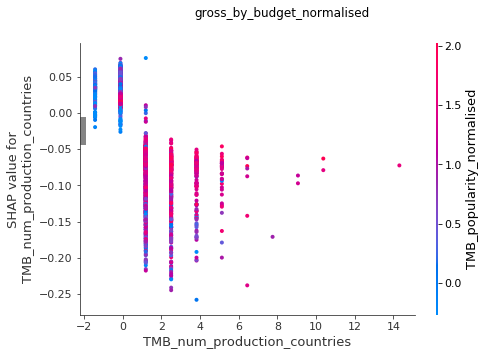

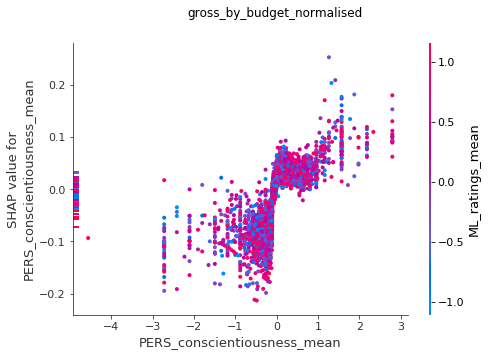

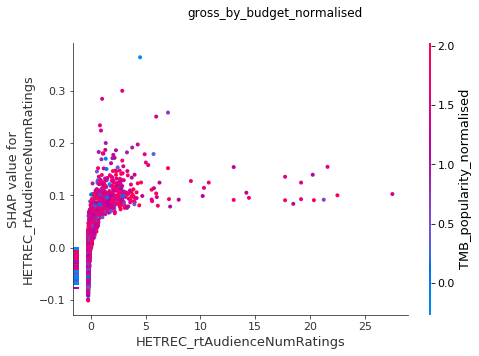

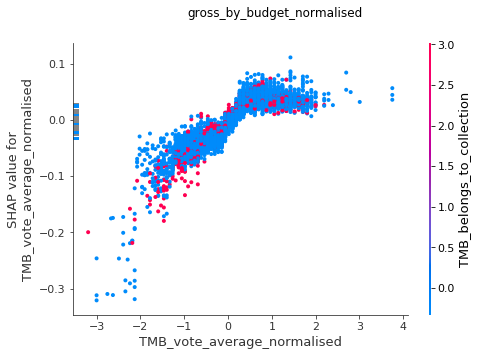

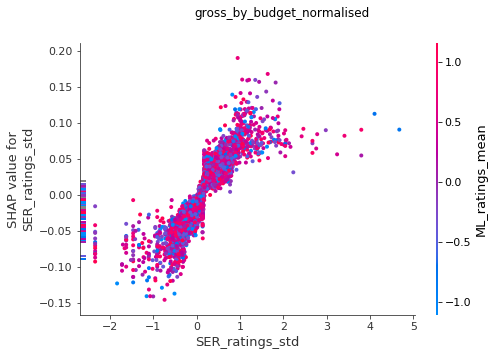

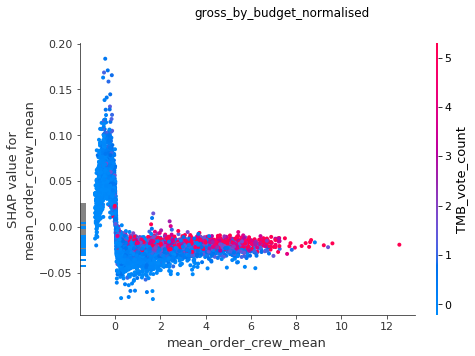

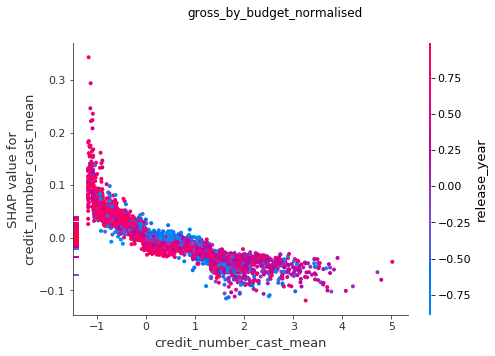

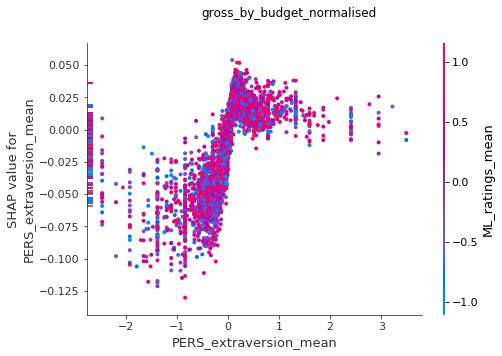

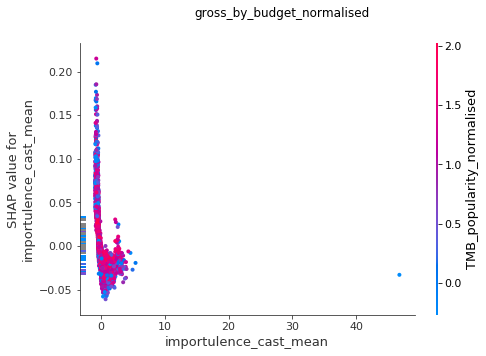

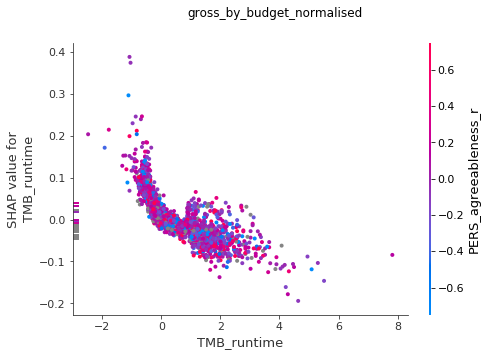

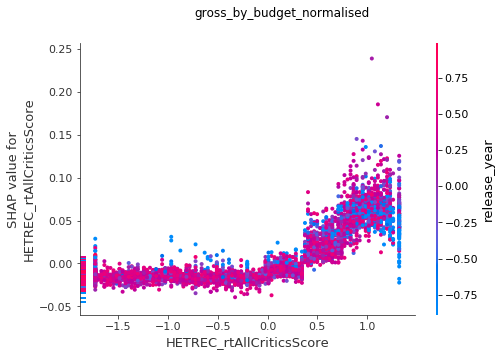

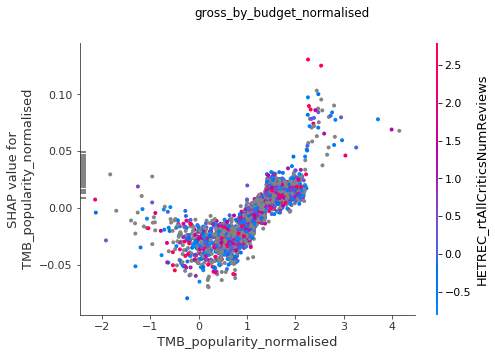

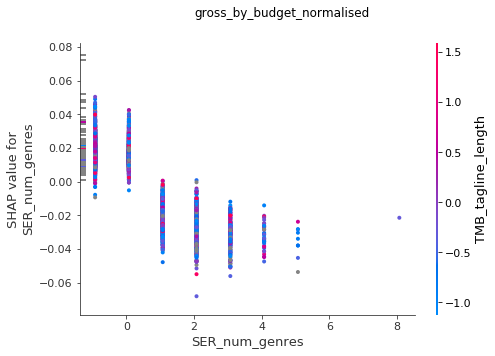

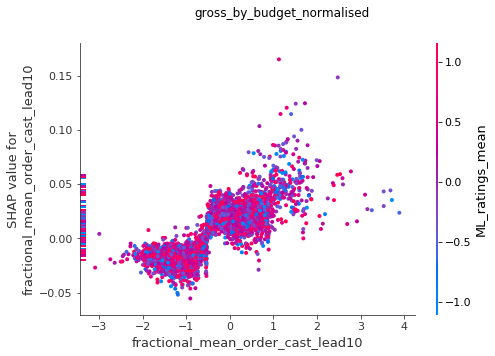

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


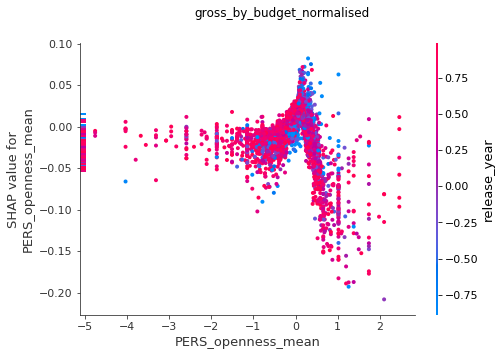

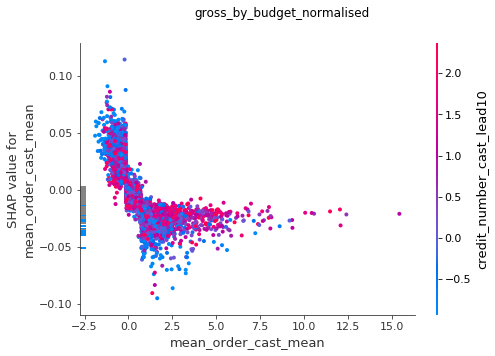

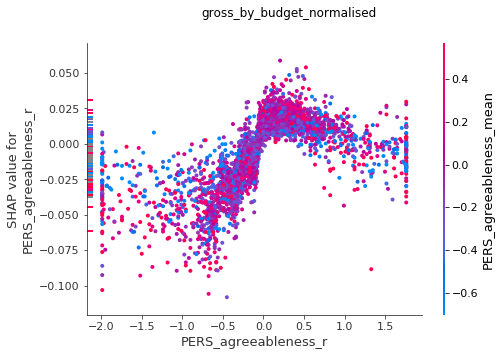

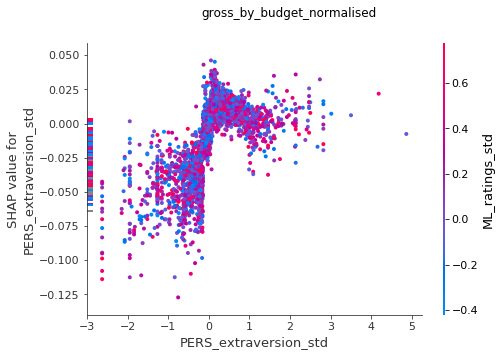

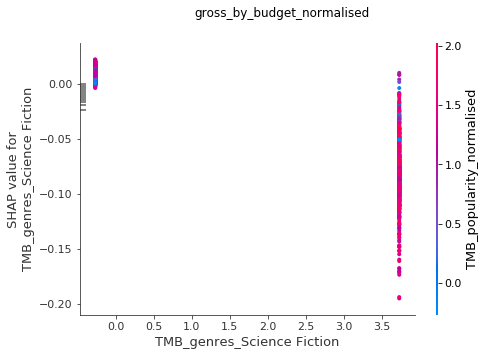

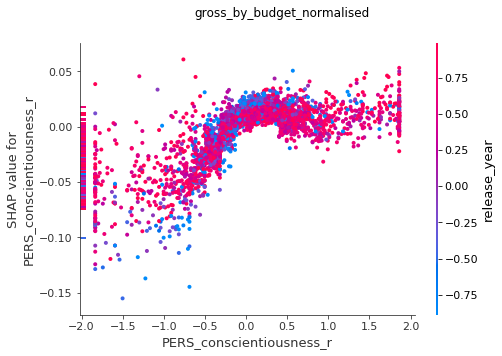

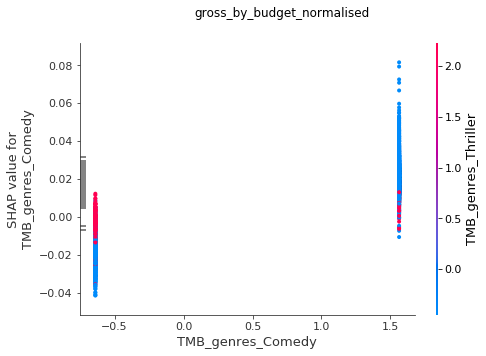

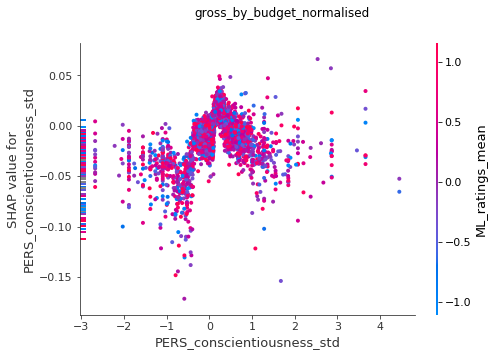

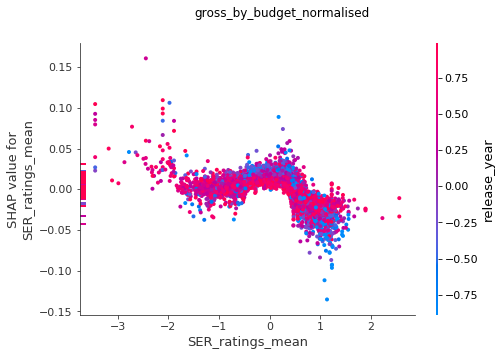

Wall time: 13min 13s


In [19]:
%%time

Treatment = "xgboost_numerical_only_with_agg_crew_cast_data"

BES_output_folder= ".."+os.sep+"Output"+os.sep

drop_cols = ["gross_normalised","budget_normalised"]

df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)

# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )

var_name = "gross_by_budget_normalised"

mask = df[var_name].notnull()

df = df[mask].copy()

colname = var_name

var_stub = var_name

var_list = [var_name]
var_stub_list = [var_stub]


(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,30),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True)


# r^2 = 0.04!!!!! Almost like other people worked to try to make films profitable!
### wait - we got .38 on earlier run with *worse data*
# difference? -> much better now we normalised the target


# release_year -> older movies, more profitable, less competition
# low profitability => not many votes (less so if film recent)
# belongs to collection => prob profitable! (less so if film recent)
# most of the gross domestic = prob not profitable!
# short movies - more likely to be profitable (more so for older movies) - really sharp cutoff at 100mins!
# international releases - *very linear* (negative) relation between domestic gross fraction and profitability (less so older movies)

In [26]:
# INT_df_ord_only["release_year"] = INT_df["release_year"]

Warning, filename truncated because it was over 50. Filenames may no longer be unique


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:09:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.09054
Will train until validation_0-rmse hasn't improved in 19.200000000000003 rounds.
[1]	validation_0-rmse:1.06532
[2]	validation_0-rmse:1.04045
[3]	validation_0-rmse:1.01687
[4]	validation_0-rmse:0.995426
[5]	validation_0-rmse:0.974817
[6]	validation_0-rmse:0.956961
[7]	validation_0-rmse:0.939165
[8]	validation_0-rmse:0.922372
[9]	validation_0-rmse:0.906129
[10]	validation_0-rmse:0.890522
[11]	validation_0-rmse:0.876205
[12]	validation_0-rmse:0.862914
[13]	validation_0-rmse:0.849936
[14]	validation_0-rmse:0.838145
[15]	validation_0-rmse:0.827368
[16]	validation_0-rmse:0.817064
[17]	validation_0-rmse:0.806836
[18]	validation_0-rmse:0.798104
[19]	validation_0-rmse:0.787825
[20]	validation_0-rmse:0.77878
[21]	validation_0-rmse:0.770426
[22]	validation_0-rmse:0.762297
[23]	validation_0-rmse:0.755367
[2

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:15:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


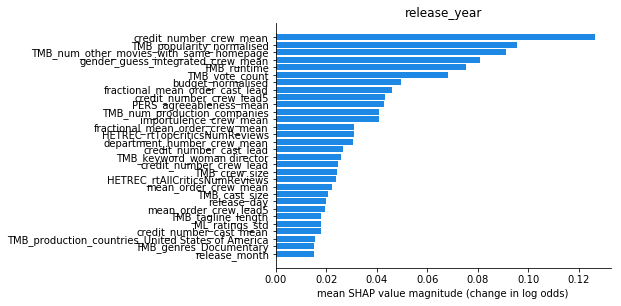

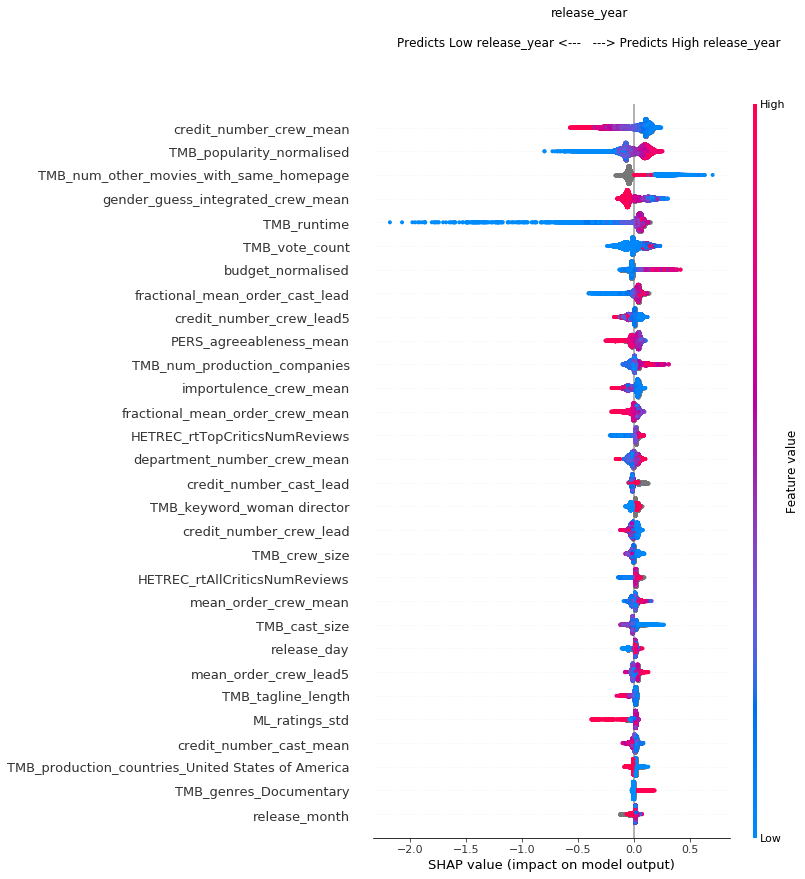

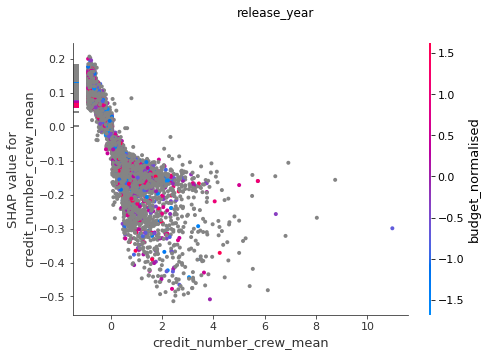

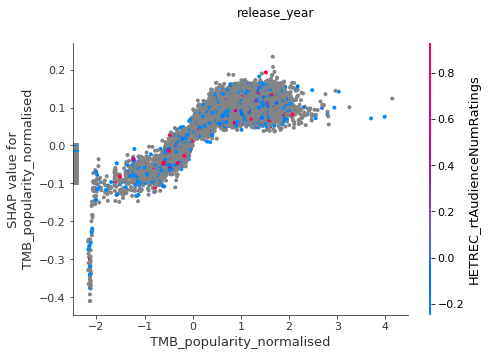

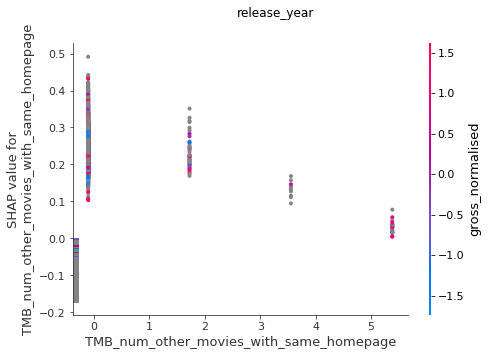

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


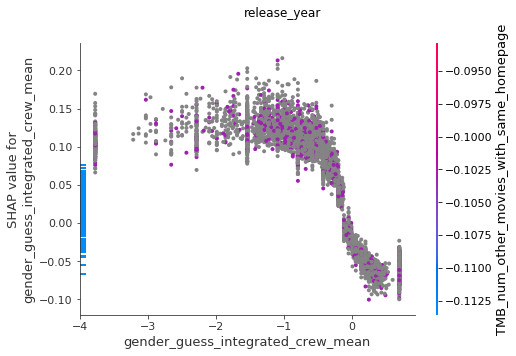

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


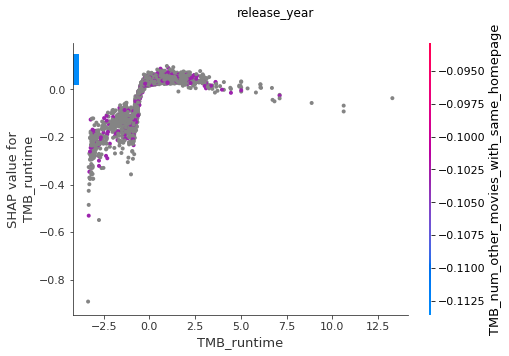

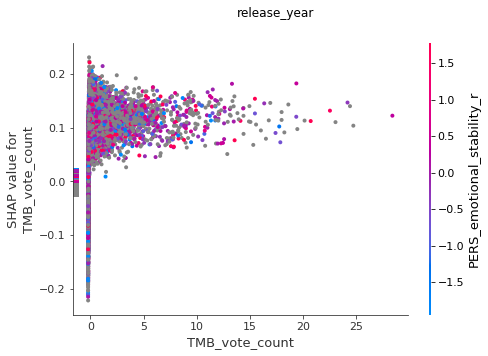

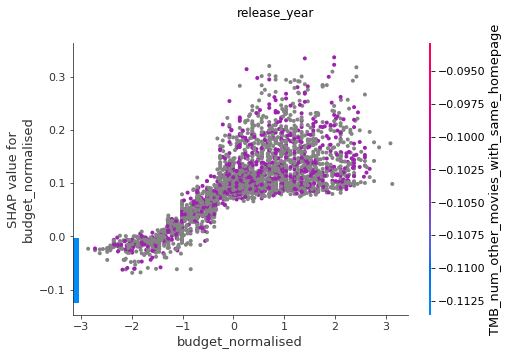

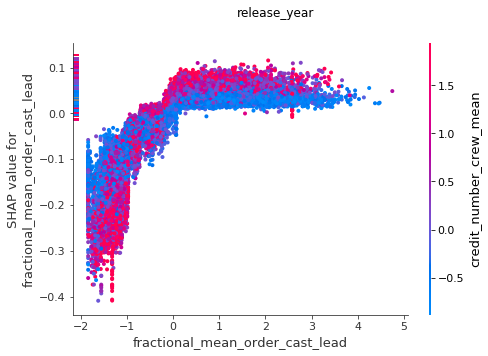

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


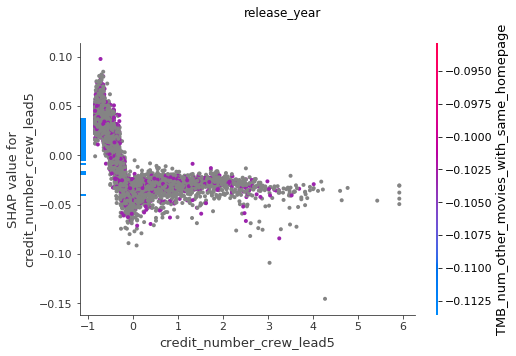

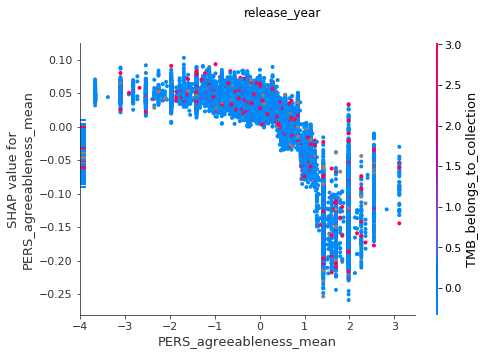

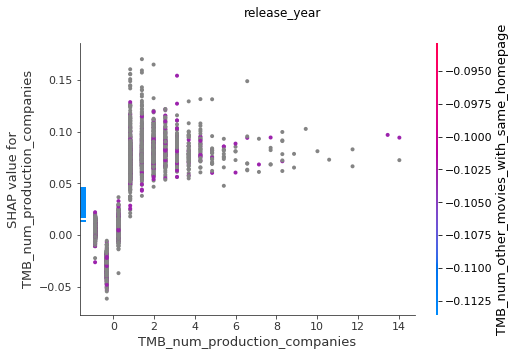

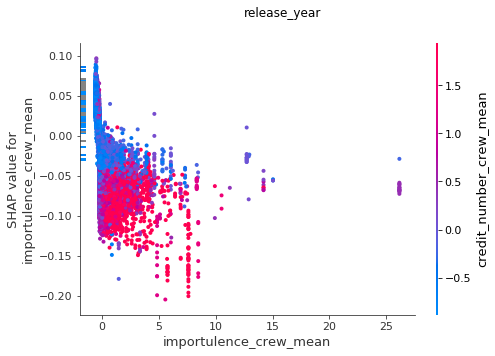

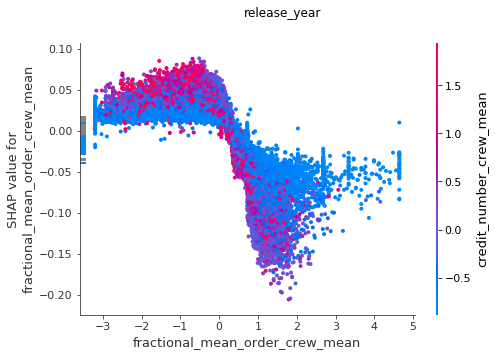

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


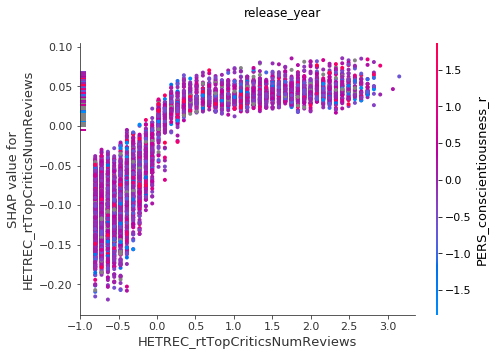

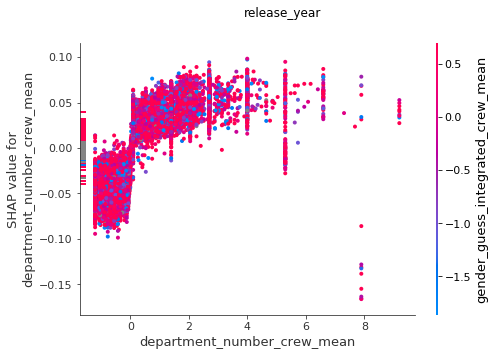

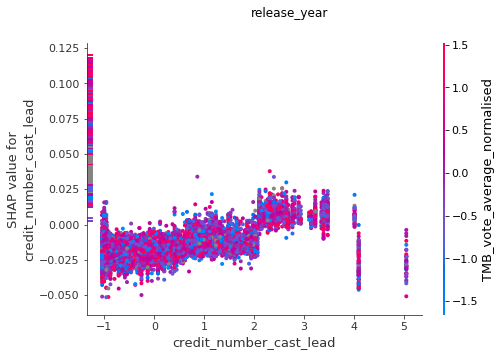

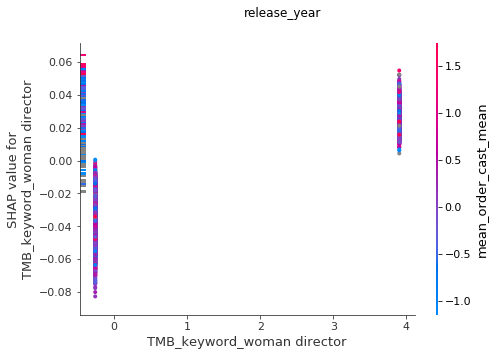

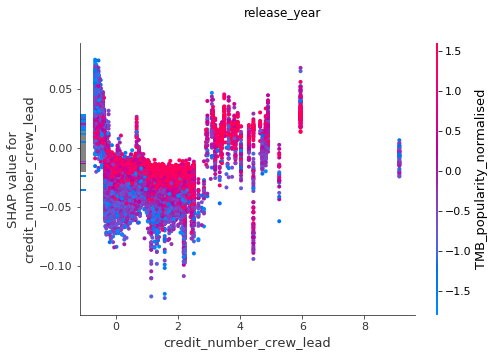

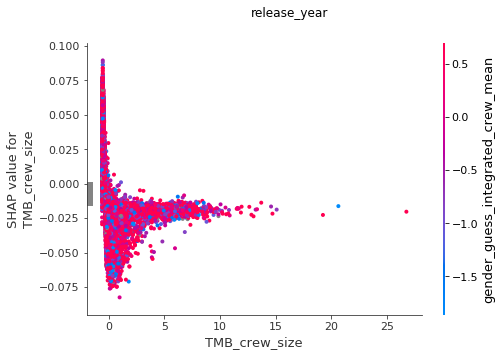

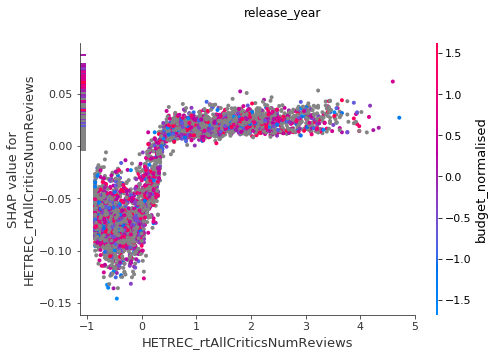

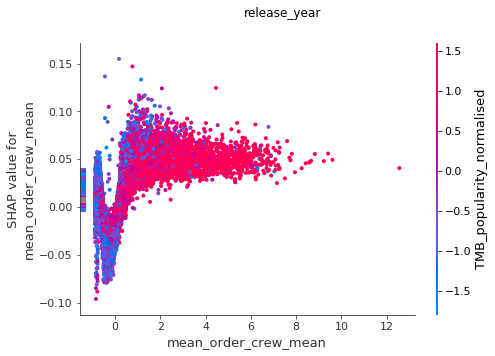

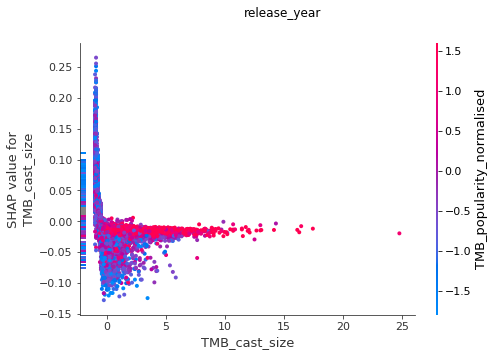

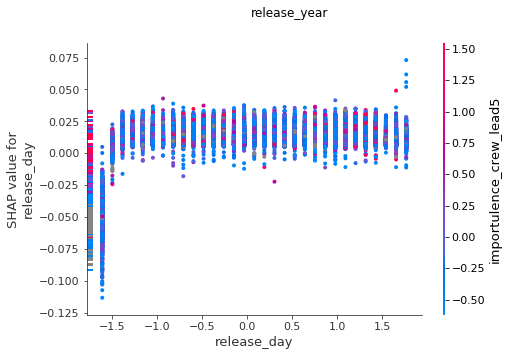

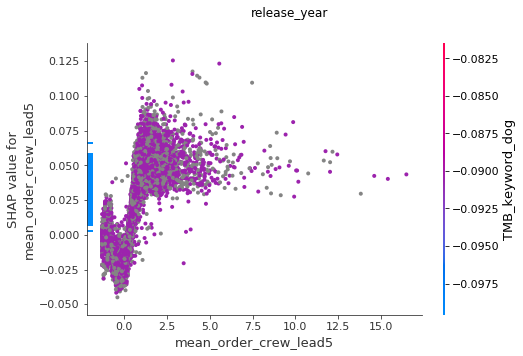

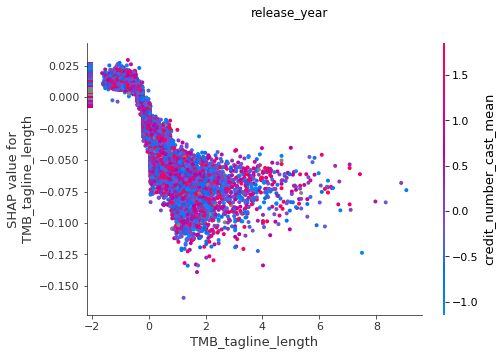

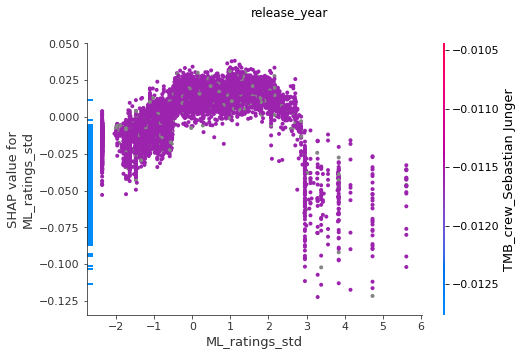

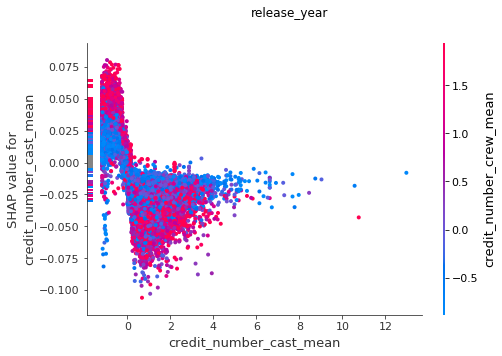

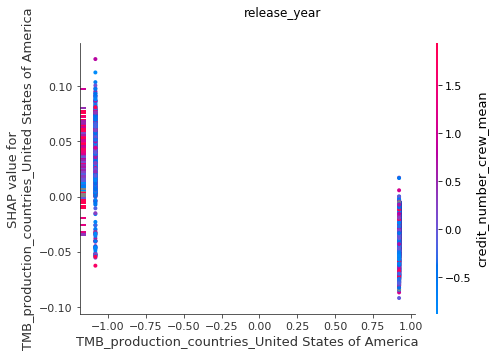

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


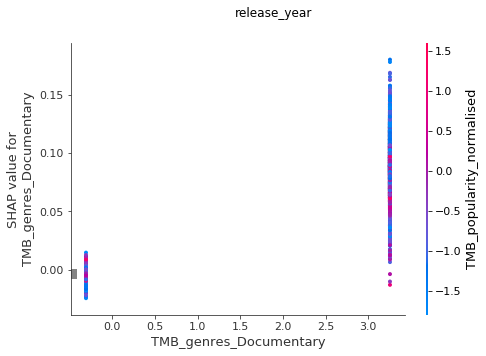

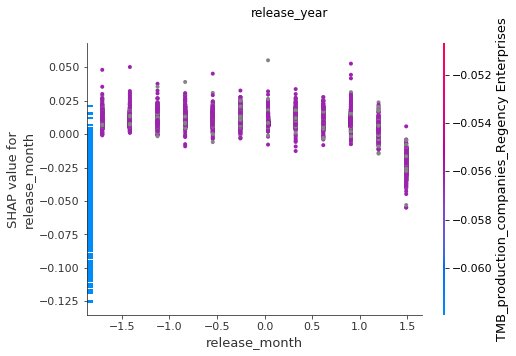

Wall time: 34min 40s


In [27]:
%%time

Treatment = "xgboost_numerical_only_with_agg_crew_cast_data"

BES_output_folder= ".."+os.sep+"Output"+os.sep

# drop_cols = ["gross_normalised","budget_normalised"]
drop_cols = []
df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)

# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )

var_name = "release_year"

mask = df[var_name].notnull()

df = df[mask].copy()

colname = var_name

var_stub = var_name

var_list = [var_name]
var_stub_list = [var_stub]


(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,30),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True)



Warning, filename truncated because it was over 50. Filenames may no longer be unique


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:44:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.10314
Will train until validation_0-rmse hasn't improved in 19.1 rounds.
[1]	validation_0-rmse:1.08315
[2]	validation_0-rmse:1.06627
[3]	validation_0-rmse:1.04876
[4]	validation_0-rmse:1.03321
[5]	validation_0-rmse:1.01739
[6]	validation_0-rmse:1.00388
[7]	validation_0-rmse:0.991161
[8]	validation_0-rmse:0.979989
[9]	validation_0-rmse:0.96796
[10]	validation_0-rmse:0.956926
[11]	validation_0-rmse:0.94791
[12]	validation_0-rmse:0.938602
[13]	validation_0-rmse:0.93009
[14]	validation_0-rmse:0.922433
[15]	validation_0-rmse:0.915069
[16]	validation_0-rmse:0.908169
[17]	validation_0-rmse:0.901567
[18]	validation_0-rmse:0.895938
[19]	validation_0-rmse:0.890507
[20]	validation_0-rmse:0.885338
[21]	validation_0-rmse:0.880676
[22]	validation_0-rmse:0.875884
[23]	validation_0-rmse:0.871573
[24]	validation_0-rms

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:49:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


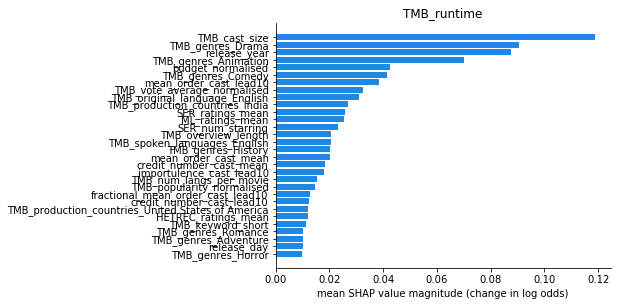

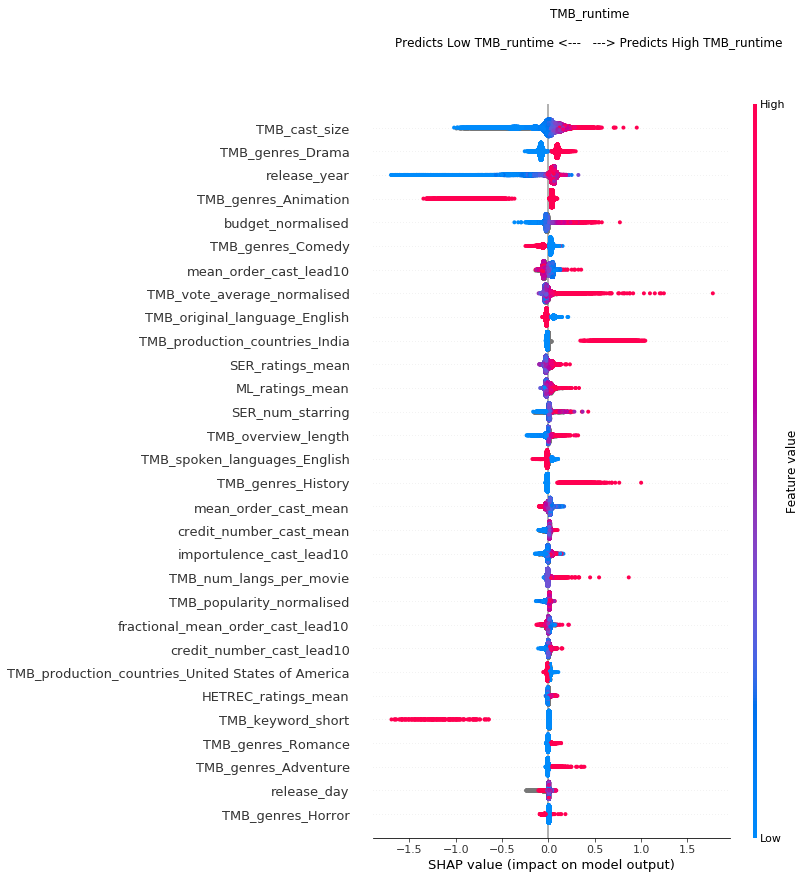

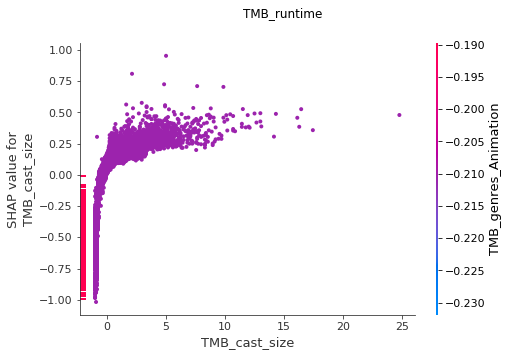

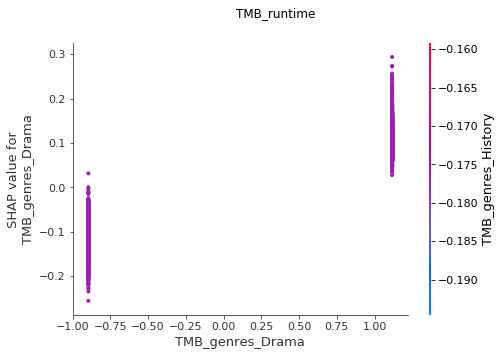

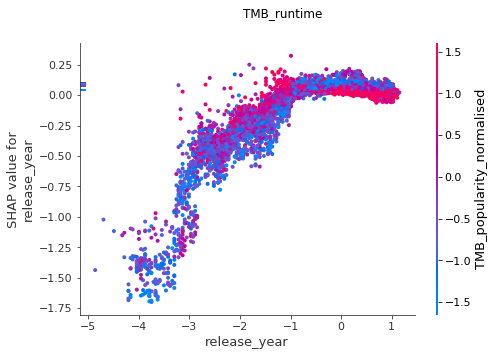

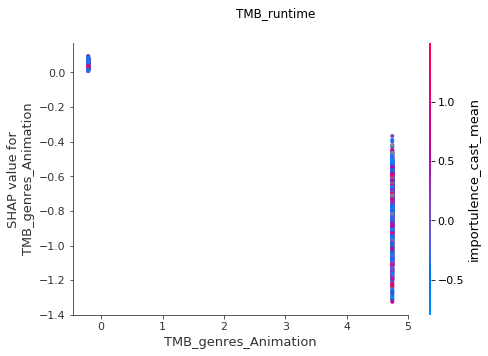

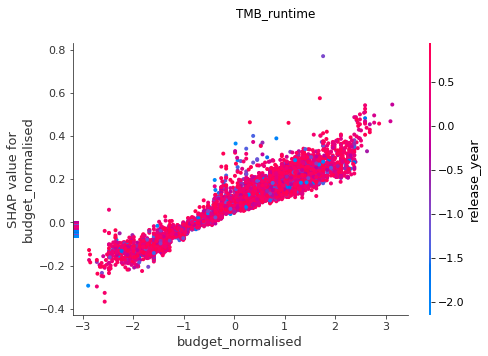

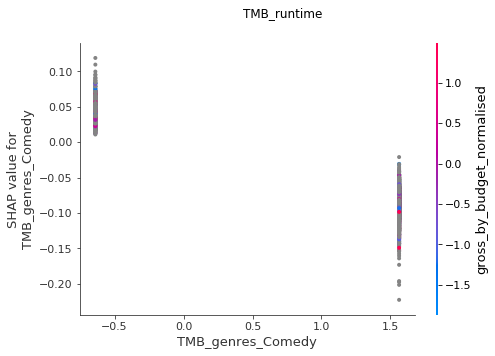

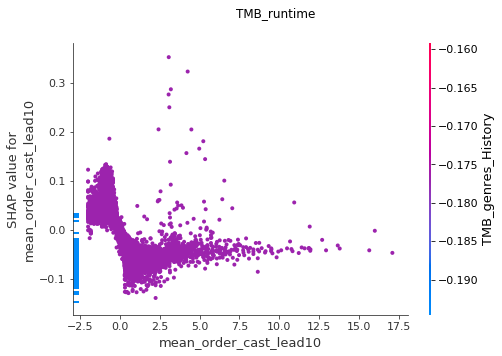

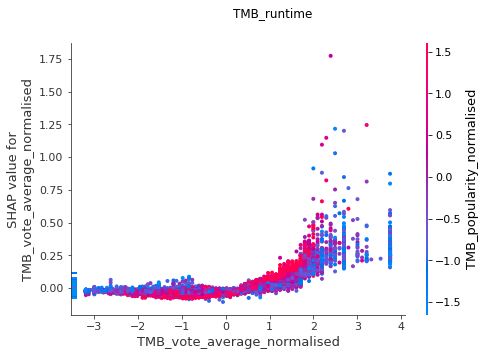

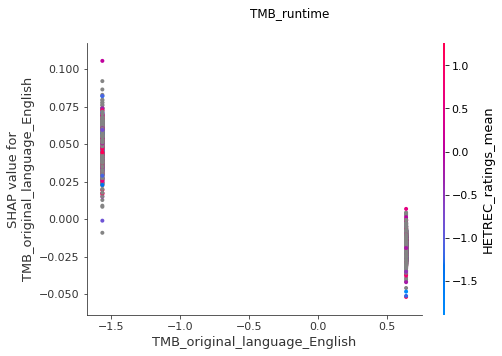

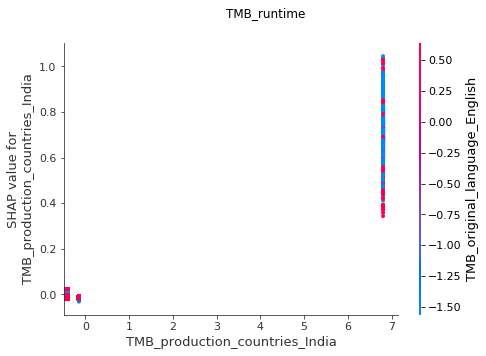

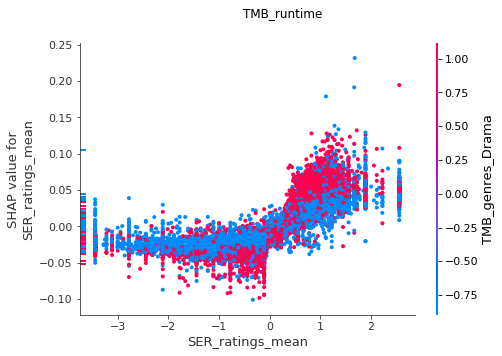

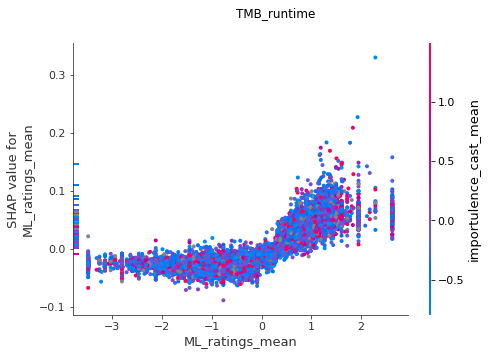

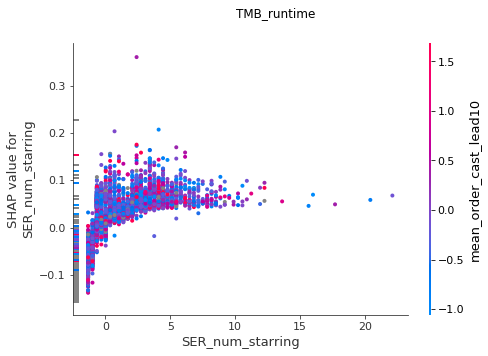

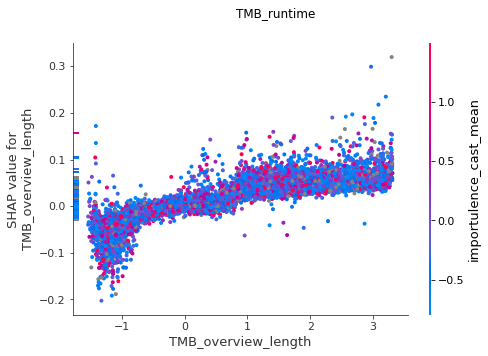

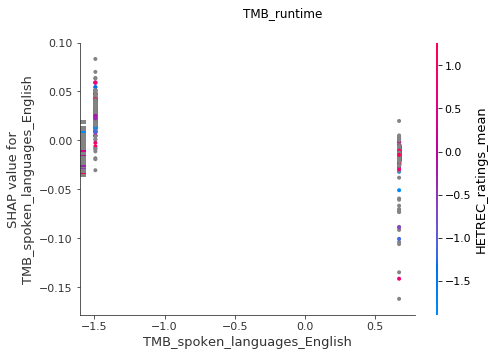

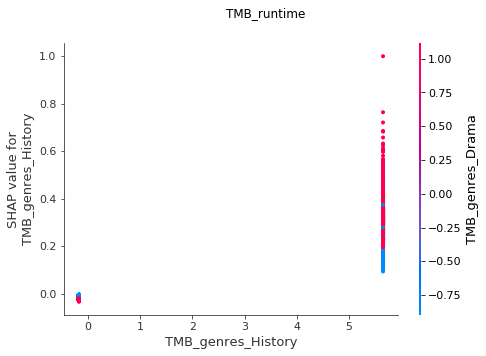

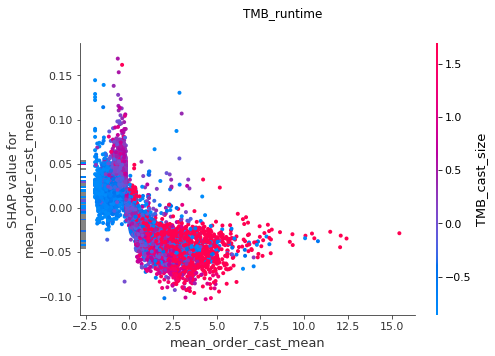

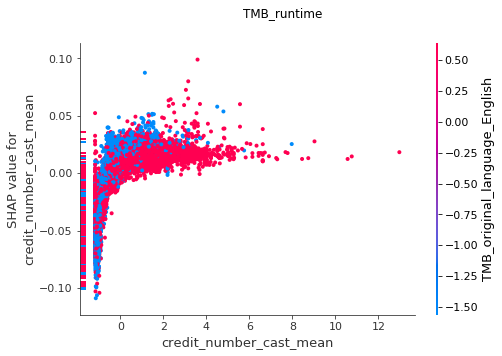

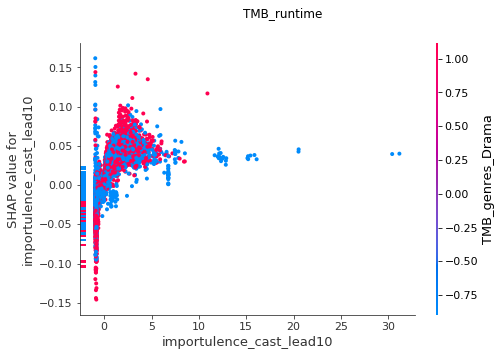

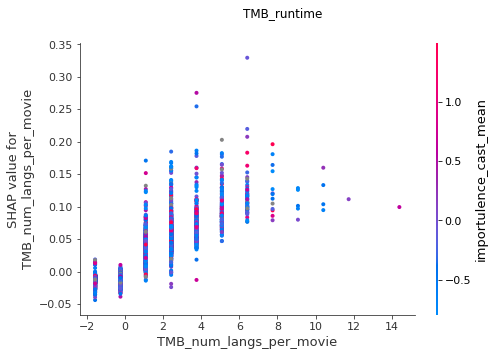

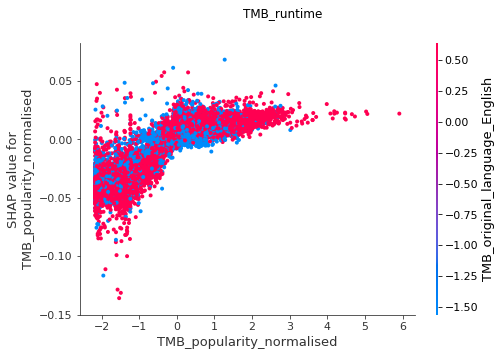

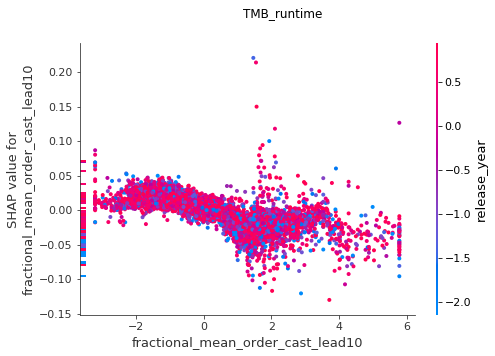

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


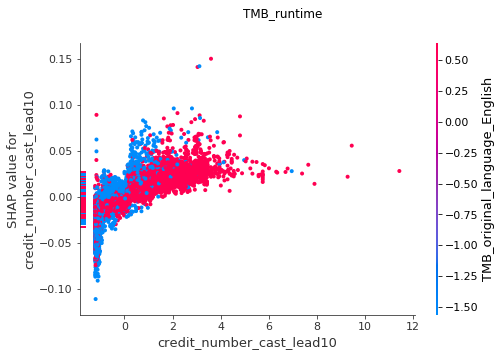

In [ ]:
%%time

Treatment = "xgboost_numerical_only_with_agg_crew_cast_data"

BES_output_folder= ".."+os.sep+"Output"+os.sep

# drop_cols = ["gross_normalised","budget_normalised"]
drop_cols = []
df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)

# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )

var_name = "TMB_runtime"

mask = df[var_name].notnull()

df = df[mask].copy()

colname = var_name

var_stub = var_name

var_list = [var_name]
var_stub_list = [var_stub]


(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,30),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True)



In [11]:
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )
          
            

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False ):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(BES_output_folder,"xgb_census"+Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves)

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values)
    

In [12]:
optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1



def create_train(drop_other_waves):
    keep_list = df.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return df[keep_list]


def create_target(target_var):
    
    return df[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 508,
 max_depth=6,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=5e-05,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)

